In [ ]:
import torch
import torch.nn.functional as F     # 激励函数都在这
import torch.nn as nn
from torch.autograd import Variable   #torch.autograd.Variable（）将张量转换为计算图中的节点

import matplotlib.pyplot as plt

In [31]:
#1.介绍一种快速搭建NN的方法
#回顾：最标准定义NN的方法
class Network(nn.Module):
    def __init__(self,n_features,n_hidden,n_output):
        super(Network,self).__init__()         #表示nerwork的__init__继承了nn.Module的__init__
        self.hidden = nn.Linear(in_features=n_features,out_features=n_hidden)
        self.out = nn.Linear(in_features=n_hidden,out_features=n_output)
    
    def forward(self,x):
        x = F.relu(self.hidden(x))
        x = self.out(x)                              #由于是，不需要再对结果激励，也不用多处理，只需要输出即可
        return x
    
#现在；快速搭建法：
net2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)
#则两个办法搭建的NN是一样的,但是第一个办法没有显示出relu（因为这只是一个class里面的function（F.relu）），
#第二个办法把ReLU当作了一个class，但是没有显示出layer的名字
net1=Network(1,10,1)
print(net1)
print(net2)

Network(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)
Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


In [32]:
#2.保存和提取神经网络，因为有时候神经网络耗时长，可能不是一次就能完成，所以要保存提取
#分为两种，保存提取整个神经网络 和 只保存提取神经网络参#下面希望保存NN：
#1/保存整个NN（包含形式和其参数）：
torch.save(net1, 'net.pkl')  # 保存整个网络
# 假设数据
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())  # noisy y data (tensor), shape=(100, 1)

def save():
    # 建网络
    net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1)
    )
    optimizer = torch.optim.SGD(net1.parameters(), lr=0.5)
    loss_func = torch.nn.MSELoss()

    # 训练
    for t in range(100):
        prediction = net1(x)
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #下面希望保存NN：
    #1/保存整个NN（包含形式和其参数）：
    torch.save(net1, 'net.pkl')           #文件形式为pkl
    #2/ 只保存NN的参数，这个速度快，占内存少
    torch.save(net1.state_dict(), 'net_params.pkl') 
    
#1/ 提取整个网络：
def restore_net():
    # restore entire net1 to net2
    net2 = torch.load('net.pkl')
    prediction = net2(x)

#2/ 只提取网络参数
def restore_params():
    # 新建 net3
    net3 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1)
    )
    # 将保存的参数复制到 net3
    net3.load_state_dict(torch.load('net_params.pkl'))
    prediction = net3(x)

#显示结果：其实1/和2/最后结果都是一样的，但是推荐2/，因为这个办法整体速度快，占内存少

In [36]:
#把自己的数据导入数据集（torch.utils.data.TensorDataset）使得torch识别 和 批数据处理(torch.utils.data.Dataloader)
#注意：基本上大型的数据都要这么做，要不然就是通过utils下载
import torch
import torch.utils.data as Data
torch.manual_seed(1)    # reproducible         #为GPU设置随机数种子，当种子为1时候得到的结果是一定的

BATCH_SIZE = 5      # 批训练的数据个数

x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)

# 先转换成 torch 能识别的 Dataset
torch_dataset = Data.TensorDataset(x, y)          #tensor数据x和y作为参数传入
print(torch_dataset[0][0])       #torch_dataset 可以看做dim为10*2的tensor数据

# 把 dataset 放入 DataLoader
loader = Data.DataLoader(
    torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据,默认是所有可用线程，应该是大于2的，所以比2快
)

for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        # 打出来一些数据
        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

tensor(1.)
Epoch:  0 | Step:  0 | batch x:  [ 5.  7. 10.  3.  4.] | batch y:  [6. 4. 1. 8. 7.]
Epoch:  0 | Step:  1 | batch x:  [2. 1. 8. 9. 6.] | batch y:  [ 9. 10.  3.  2.  5.]
Epoch:  1 | Step:  0 | batch x:  [ 4.  6.  7. 10.  8.] | batch y:  [7. 5. 4. 1. 3.]
Epoch:  1 | Step:  1 | batch x:  [5. 3. 2. 1. 9.] | batch y:  [ 6.  8.  9. 10.  2.]
Epoch:  2 | Step:  0 | batch x:  [ 4.  2.  5.  6. 10.] | batch y:  [7. 9. 6. 5. 1.]
Epoch:  2 | Step:  1 | batch x:  [3. 9. 1. 8. 7.] | batch y:  [ 8.  2. 10.  3.  4.]


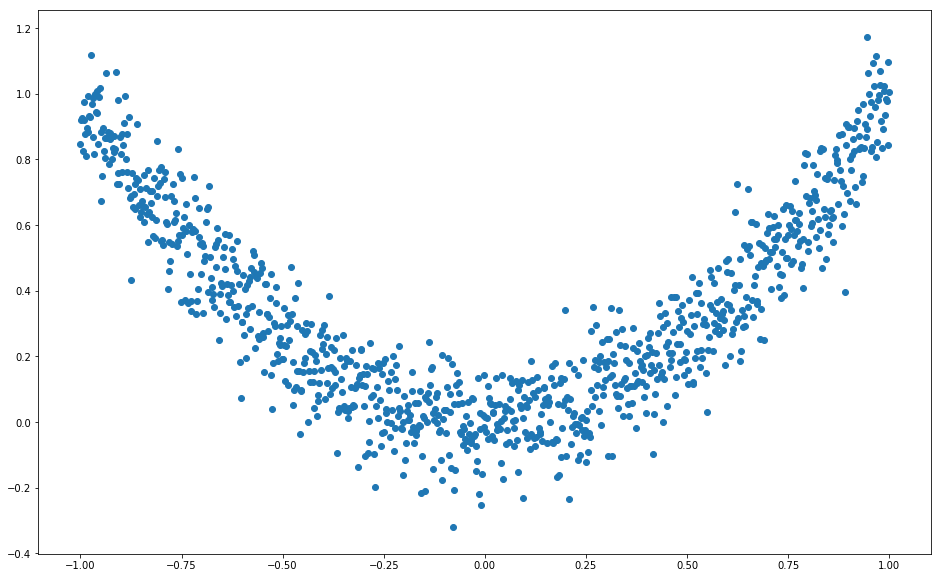

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4


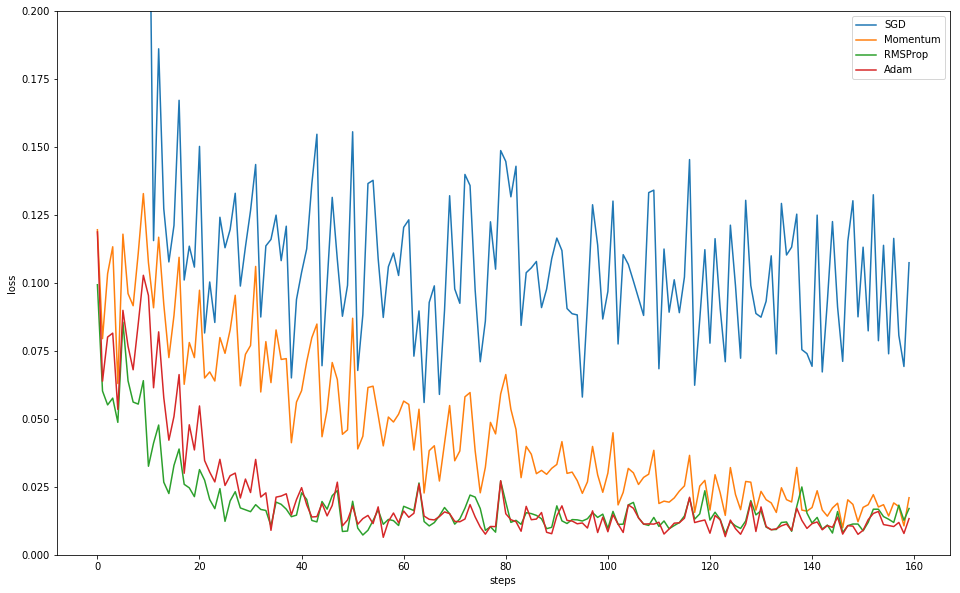

In [4]:
#不同的optimizer比较：
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt

torch.manual_seed(1)    # reproducible

LR = 0.01
BATCH_SIZE = 32
EPOCH = 5

# fake dataset
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

# plot dataset
plt.figure(figsize=(16,10))
plt.scatter(x.numpy(), y.numpy())
plt.show()

# 使用上节内容提到的 data loader
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

# 默认的 network 形式
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)   # hidden layer
        self.predict = torch.nn.Linear(20, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

# 为每个优化器创建一个 net
net_SGD         = Net()
net_Momentum    = Net()
net_RMSprop     = Net()
net_Adam        = Net()
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]        #1/ 打包nets

# different optimizers
opt_SGD         = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum    = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop     = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam        = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]  #2/ 打包optimizer

loss_func = torch.nn.MSELoss()
losses_his = [[], [], [], []]   #3/ 记录 training 时不同神经网络的 loss，打包loss

for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    for step, (b_x, b_y) in enumerate(loader):
        b_x=Variable(b_x)
        b_y=Variable(b_y)
        # 对每个优化器, 优化属于他的神经网络
        for net, opt, l_his in zip(nets, optimizers, losses_his):     #zip的作用是打包整三个，indice一一对应
            output = net(b_x)              # get output for every net
            loss = loss_func(output, b_y)  # compute loss for every net
            opt.zero_grad()                # clear gradients for next train
            loss.backward()                # backpropagation, compute gradients
            opt.step()                     # apply gradients
            l_his.append(loss.data.numpy())     # loss recoder  #l_his对应于4*1维列表的第1维度的地方，也是一个数组，
                                                                #最开始是空数组，不断往里面加数字

labels=['SGD','Momentum','RMSProp','Adam']
plt.figure(figsize=(16,10))
for i,l_his in enumerate(losses_his):     #losses_his本质是二维的数组，加入了i，用enumerate函数，则能构造出i=0，1，2，3分别对应四个方法
    plt.plot(l_his,label=labels[i])        #plot函数可以只写入y轴l_his,不写x轴
plt.legend(loc='best')
plt.xlabel('steps')
plt.ylabel('loss')
plt.ylim((0,0.2))
plt.show()